# LACONEU 2025: Methods of information theory for brain data
# Tutorial # 3: Estimators of entropy for the HOI measure


### Objective:
In this tutorial, we compare for 3 PGM sistems (a synergistic, a redundant and a joint system) the result of the HOI measures when using different entropy estimators. Because the data is gaussian, we know that Gaussian copula and the gaussian (using the gaussian entropy) estimators are the ground thruth. We will compare the results of the HOI measure using the following estimators:
- Gaussian copula
- Gaussian entropy
- KNN
- Kernel

In [1]:
import numpy as np
from scipy.linalg import block_diag

import matplotlib.pyplot as plt

import hoi

In [2]:
def generate_synergistic_system(n, samples=1000, c=1):
    """
    Generate a synergy-dominated system (S-system) using normal distributions.
    
    In an S-system, the n variables (X_1, ..., X_n) are marginally independent 
    (each drawn from a standard normal distribution). A single variable Y is 
    then generated by taking the sum of all X_i (scaled by a constant c) and 
    adding independent normal noise.
    
    Args:
        n (int): Number of X variables to generate.
        samples (int, optional): Number of samples to draw for each variable. 
                                 Defaults to 1000.
        c (float, optional): Coefficient used to scale the sum of the X variables 
                             in generating Y. Defaults to 1.
    
    Returns:
        np.ndarray: A 2D array of shape (n + 1, samples), where
            - The first n rows correspond to the X_i variables,
            - The last row corresponds to Y.
    
    Example:
        >>> data = generate_S_system(n=3, samples=5, c=2)
        >>> data.shape
        (4, 5)
        # data[0,:] -> X_1 samples
        # data[1,:] -> X_2 samples
        # data[2,:] -> X_3 samples
        # data[3,:] -> Y samples
    """
    # Create a list of n independent normal variables, each shape (samples,).
    X = [np.random.normal(size=samples) for _ in range(n)]
    
    # Generate Y by taking c * (sum of X_i) plus an independent normal noise term.
    Y = c * sum(X) + np.random.normal(size=samples)
    
    # Stack the n X variables and Y into a single array of shape (n+1, samples).
    return np.vstack((X, Y))


def synergistic_system_cov_matrix(n, c):
    """
    Create the theoretical covariance matrix for the synergistic-system.
    
    The S-system has n marginally independent variables X_i (each with variance 1) 
    and a variable Y = c * (sum of X_i) + noise. The resulting covariance matrix 
    is of dimension (n+1) x (n+1), where the last row and column correspond to Y.
    
    Args:
        n (int): Number of X variables.
        c (float): Coefficient scaling the sum of X in generating Y.
    
    Returns:
        np.ndarray: The (n+1) x (n+1) covariance matrix for the S-system.
    
    Explanation of the entries:
        - Each X_i has variance 1 on the diagonal.
        - Y has variance var_Y = n * c^2 + 1. (n * c^2 is from the sum of X_i 
          scaled by c; +1 is from the independent noise in Y.)
        - The covariance between each X_i and Y is c.
        - Off-diagonal entries among X_i are zero, since X_i are independent.
    
    Example:
        >>> Sigma = S_system_cov_matrix(n=3, c=2)
        >>> Sigma.shape
        (4, 4)
        # Sigma[:3, :3] is diagonal with 1's for X_i
        # Sigma[3, 3] is var_Y
    """
    # For X_i ~ N(0, 1)
    var_X_i = 1
    
    # Cov(X_i, Y) = c, because Y = c * sum(X_i) + noise
    cov_X_i_Y = c
    
    # Variance of Y = n*c^2 + 1
    var_Y = n * c**2 + 1
    
    # Initialize the covariance matrix of shape (n+1, n+1) with zeros
    Sigma = np.zeros((n + 1, n + 1))
    
    # Fill the diagonal for the X_i variables
    np.fill_diagonal(Sigma[:n, :n], var_X_i)
    
    # Fill the covariance between each X_i and Y
    Sigma[:n, n] = cov_X_i_Y  # row i, col Y
    Sigma[n, :n] = cov_X_i_Y  # row Y, col i
    
    # Fill the variance of Y
    Sigma[n, n] = var_Y
    
    return Sigma


def generate_redundant_system(n, samples=1000, c=1):
    """
    Generate a redundancy-dominated system (R-system) using normal distributions.
    
    In an R-system, we first generate a variable Y from a standard normal 
    distribution. Each X_i is then generated as a linear function of Y (scaled 
    by c) plus independent normal noise. Conditional on Y, the X_i variables 
    become independent. 
    
    Args:
        n (int): Number of X variables to generate.
        samples (int, optional): Number of samples to draw for each variable. 
                                 Defaults to 1000.
        c (float, optional): Coefficient scaling Y in generating each X_i. 
                             Defaults to 1.
    
    Returns:
        np.ndarray: A 2D array of shape (n + 1, samples), where
            - The first n rows are the X_i variables,
            - The last row is the Y variable.
    
    Example:
        >>> data = generate_R_system(n=3, samples=5, c=2)
        >>> data.shape
        (4, 5)
        # data[0,:] -> X_1 samples
        # data[1,:] -> X_2 samples
        # data[2,:] -> X_3 samples
        # data[3,:] -> Y samples
    """
    # Generate the variable Y ~ N(0, 1)
    Y = np.random.normal(size=samples)
    
    # Generate each X_i as c * Y plus an independent noise term
    X = [c * Y + np.random.normal(size=samples) for _ in range(n)]
    
    # Stack X and Y into an array of shape (n+1, samples)
    return np.vstack((X, Y))


def redundant_system_cov_matrix(n, c):
    """
    Create the theoretical covariance matrix for the R-system.
    
    The R-system has a variable Y ~ N(0,1). Each X_i is generated as 
    X_i = c * Y + noise (noise ~ N(0,1)). The resulting covariance matrix 
    is of dimension (n+1) x (n+1), where the last row/column corresponds to Y.
    
    Args:
        n (int): Number of X variables.
        c (float): Coefficient scaling Y when generating each X_i.
    
    Returns:
        np.ndarray: The (n+1) x (n+1) covariance matrix for the R-system.
    
    Explanation of the entries:
        - Y has variance 1 on the diagonal.
        - Each X_i has variance c^2 + 1 (because X_i = c*Y + noise, each with 
          variance c^2 + 1).
        - Cov(X_i, X_j) = c^2 for i != j (they share dependence on Y).
        - Cov(X_i, Y) = c.
    
    Example:
        >>> Sigma = R_system_cov_matrix(n=3, c=2)
        >>> Sigma.shape
        (4, 4)
        # The top-left 3x3 block is the covariances among X_1..X_3
        # Sigma[3,3] is the variance of Y.
    """
    # The variance of each X_i is c^2 + 1
    var_X_i = c**2 + 1
    
    # The covariance among different X_i is c^2 (since they share Y in common)
    cov_X_i_X_j = c**2
    
    # The covariance between each X_i and Y is c
    cov_X_i_Y = c
    
    # Y has variance 1
    var_Y = 1
    
    # Start with a matrix full of c^2 to fill off-diagonal X_i-X_j
    Sigma = np.full((n + 1, n + 1), cov_X_i_X_j)
    
    # Fill the diagonal with var_X_i for X_1..X_n 
    # and later we'll fix the diagonal entry for Y
    np.fill_diagonal(Sigma, var_X_i)
    
    # Covariances between each X_i and Y
    Sigma[:n, n] = cov_X_i_Y
    Sigma[n, :n] = cov_X_i_Y
    
    # Fill variance of Y on the diagonal
    Sigma[n, n] = var_Y
    
    return Sigma


In [3]:
T=2000
n = 3
n_cs = 10
meas_names = ['TC', 'DTC', 'O', 'S']
n_meas = len(meas_names)

methods = ['gc', 'gauss', 'knn', 'kernel']
#methods = ['gc', 'gauss', 'kernel']
#methods = ['gc', 'gauss']
n_methods = len(methods)

redundant_measures = np.zeros((n_cs, n_meas, n_methods))
synergistic_measures = np.zeros((n_cs, n_meas, n_methods))
joint_measures = np.zeros((n_cs, n_meas, n_methods))
cs = np.linspace(0, 1, n_cs)
for c_id, c in enumerate(cs):
    
    print('Computing for c =', c)
    
    # Redundant
    redundant_C = redundant_system_cov_matrix(n, c)
    redundant_D = np.random.multivariate_normal(np.zeros(redundant_C.shape[0]), redundant_C, size=T)
    
    for metric_id, metric_func in enumerate([hoi.metrics.TC, hoi.metrics.DTC, hoi.metrics.Oinfo, hoi.metrics.Sinfo]):
        h = metric_func(redundant_D, verbose='WARNING')
        for m_id, method in enumerate(methods):
            print(f'\tComputing {metric_func.__name__} for system Redundant, method', method)
            redundant_measures[c_id, metric_id, m_id] = h.fit(n+1, n+1, method=method)[0,0]
    
    # Synergistic
    synergistic_C = synergistic_system_cov_matrix(n, c)
    synergistic_D = np.random.multivariate_normal(np.zeros(synergistic_C.shape[0]), synergistic_C, size=T)
    
    for metric_id, metric_func in enumerate([hoi.metrics.TC, hoi.metrics.DTC, hoi.metrics.Oinfo, hoi.metrics.Sinfo]):
        h = metric_func(synergistic_D, verbose='WARNING')
        for m_id, method in enumerate(methods):
            print(f'\tComputing {metric_func.__name__} for system Synergistic, method', method)
            synergistic_measures[c_id, metric_id, m_id] = h.fit(n+1, n+1, method=method)[0,0]
    
    # Joint
    joint_C = block_diag(redundant_C, synergistic_C)
    joint_D = np.random.multivariate_normal(np.zeros(joint_C.shape[0]), joint_C, size=T)
    
    for metric_id, metric_func in enumerate([hoi.metrics.TC, hoi.metrics.DTC, hoi.metrics.Oinfo, hoi.metrics.Sinfo]):
        h = metric_func(joint_D, verbose='WARNING')
        for m_id, method in enumerate(methods):
            print(f'\tComputing {metric_func.__name__} for system Joint, method', method)
            joint_measures[c_id, metric_id, m_id] = h.fit(2*(n+1), 2*(n+1), method=method)[0,0]

Computing for c = 0.0
	Computing TC for system Redundant, method gc
	Computing TC for system Redundant, method gauss
	Computing TC for system Redundant, method knn
	Computing TC for system Redundant, method kernel
	Computing DTC for system Redundant, method gc
	Computing DTC for system Redundant, method gauss
	Computing DTC for system Redundant, method knn
	Computing DTC for system Redundant, method kernel
	Computing Oinfo for system Redundant, method gc
	Computing Oinfo for system Redundant, method gauss
	Computing Oinfo for system Redundant, method knn
	Computing Oinfo for system Redundant, method kernel
	Computing Sinfo for system Redundant, method gc
	Computing Sinfo for system Redundant, method gauss
	Computing Sinfo for system Redundant, method knn
	Computing Sinfo for system Redundant, method kernel
	Computing TC for system Synergistic, method gc
	Computing TC for system Synergistic, method gauss
	Computing TC for system Synergistic, method knn
	Computing TC for system Synergist

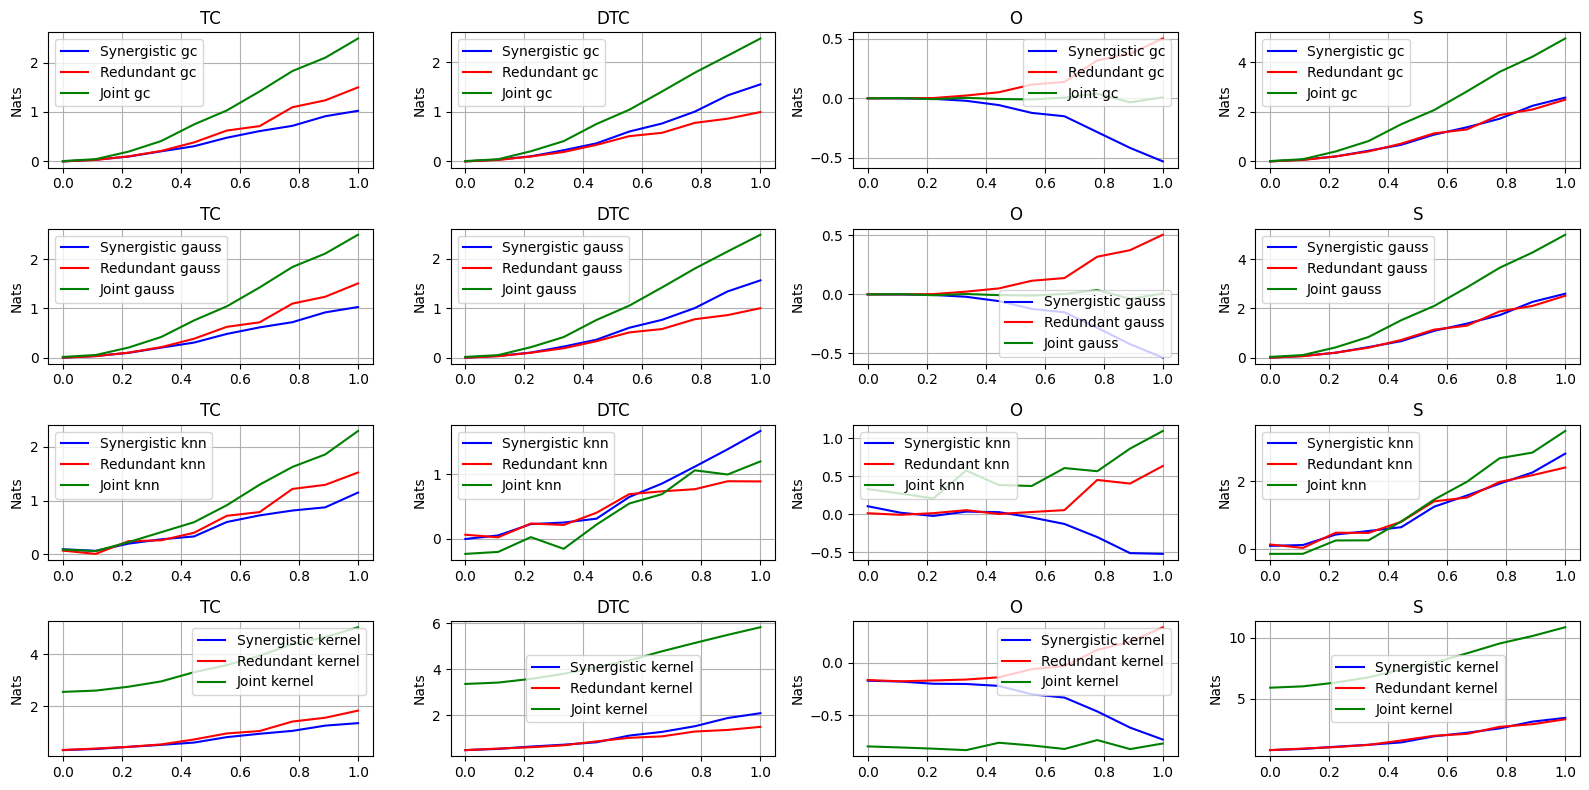

In [4]:
# Plotting measures and estimation error
fig, axes = plt.subplots(n_methods, n_meas, figsize=(16,8))
n_meas=4

for meas in range(n_meas):

    for m_id, method in enumerate(methods): 
        
        ax = axes[m_id, meas] 

        ax.plot(cs, synergistic_measures[:, meas, m_id], color='b', label=f'Synergistic {method}')
        ax.plot(cs, redundant_measures[:, meas, m_id], color='r', label=f'Redundant {method}')
        ax.plot(cs, joint_measures[:, meas, m_id], color='g', label=f'Joint {method}')

        ax.grid()
        ax.set_title(meas_names[meas])
        #if meas==0:
        ax.set_ylabel('Nats')
        ax.legend()
    
plt.tight_layout()
plt.show()